In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()                              


# reflect the tables
base.prepare(autoload_with=engine)    # This is telling the "connection" to prepare the data and "autoload" the the data from the database using the "engine"

In [6]:
# View all of the classes that automap found (aka. ALL the TABLES in the DATEBASE)
base.classes.keys()                                  


['measurement', 'station']

In [7]:
# Save references to each table ==> "Save as variable"

# Measurement Reference
measurement = base.classes.measurement

# Station Reference
station = base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.

# Query that retrieves the last date (most recent) found in the database using .order_by and then sorting in descending order
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()      ## .first() is what only retrieves the first row
most_recent_date

('2017-08-23',)

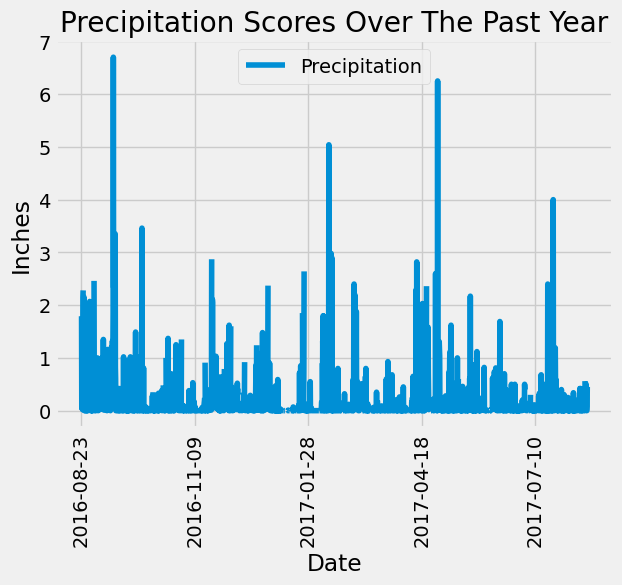

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database

# Calculate the date one year from the last date (2017-08-23) in database using "datetime as dt" from imports above
previous_year_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)          # "- dt.timedelta(days=365)" calculates to find the date 365 days prior to (2017-08-23) 

# Query to retrieve ALL (".all()") the data and precipitation scores of only days that are greater than the "previous_year_date" found above
one_calendar_year_date_prcp_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= previous_year_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
hawaii_dates_prcp_data_df = pd.DataFrame(one_calendar_year_date_prcp_data, columns= ['Date', 'Precipitation'])

# Sort the dataframe by date
hawaii_dates_prcp_data_df = hawaii_dates_prcp_data_df.sort_values('Date').reset_index(drop=True)    

# Use Pandas Plotting with Matplotlib to plot the data
# Defining x & y values for plotting
x_axis = hawaii_dates_prcp_data_df['Date']
y_axis = hawaii_dates_prcp_data_df['Precipitation']

#Creating the plot w/ labels and title
hawaii_dates_prcp_data_df.plot(x='Date', y='Precipitation', rot=90)
plt.title("Precipitation Scores Over The Past Year")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.grid(True)  # Adding in gridlines for better readability


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
hawaii_dates_prcp_data_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset

# Query to retrieve number of unique stations using "(func.count(station.id))"
total_stations = session.query(func.count(station.id)).all()
print(total_stations)

[(9,)]


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


# FROM "measurement" table ==> Selecting the station column and COUNT of "station" in that table ==> Grouping By "stations" 
# and then Order By (sorting) the counts of each of the 9 stations in descending order
station_activity = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).\
order_by(func.count(measurement.station).desc()).all()

for stations in station_activity:     ## for loop to print out "most active stations" results from the query above in the cell
    print(stations)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Query to retrieve lowest temp "func.min(measurement.tobs)" => max temp "func.max(measurement.tobs)" => avg temp "func.avg(measurement.tobs)" 
most_active_station_temp_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').all()             ## filter(measurement.station == 'USC00519281') only retrieves these temp stats from 
print(most_active_station_temp_stats)                              ## the most active station which was found above in the "station_activity" query


[(54.0, 85.0, 71.66378066378067)]


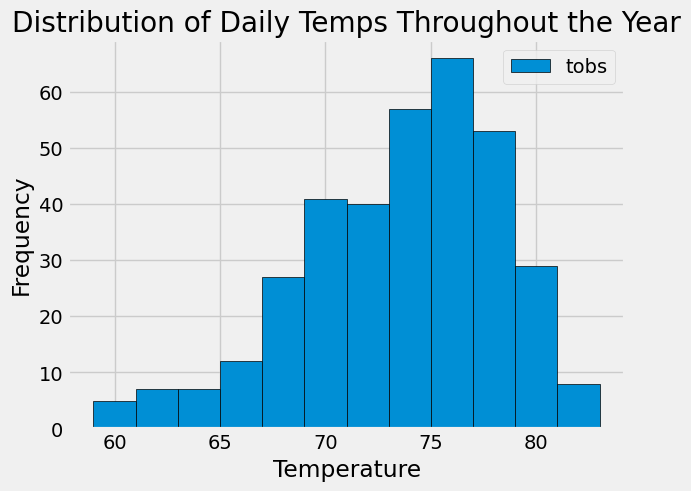

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query to retrieve ALL "tobs" data from measurement table (temp date) for the most active station 
#over the last 12 months "(measurement.date >= previous_year_date, measurement.station == 'USC00519281')" ==> "previous_year_date" was defined above!
top_station_last_year_temp = session.query(measurement.tobs).\
    filter(measurement.date >= previous_year_date, measurement.station == 'USC00519281').all()

# Coverting results from query "top_station_last_year_temp" into a DataFrame
top_station_last_year_temp = pd.DataFrame(top_station_last_year_temp, columns=['Temperature'])

# Create the histogram using df.hist() method and setting the histogram into 12 bins for 12 months of a year
top_station_last_year_temp.hist(bins=12, edgecolor='black')  # Adding black edges to bins for better readability (edgecolor = 'black')

# Adding x & y-axis labels and title
plt.title('Distribution of Daily Temps Throughout the Year')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)  # Adding gridlines for better readability
plt.legend(['tobs'])  # Adding a legend

# Displaying the histogram
plt.show()


# Close Session

In [16]:
# Close Session
session.close()